### Mustafa Kutay Yabas - EC581 - 26.11.2016
# Assignment #4
###  Oversold Strategy

Design a long-only trading strategy for BIST100 index that bets on reversals after the indes becomes oversold


__Buy Signal__

* $Low \le BBands_{Low}(n,s)$ and $RSI(m) \le c$ here $n, s, m$ are parameters and $c$ is a fixed threshold
* Example $Low \le BBands_{Low}(65,2)$ and $RSI(14) \le 30$
* Whenever this rule turns on, send a market order and assume that the order is executed at the opening price of the next dat. i.e. prefer="Open" in quantstrat
* Add one lot each time we have a new buy signal


__Sell Signal__
* Close the position whenever $Close \ge BBands_{Low}(n,s_{2})$ where $s_{2}$ is another parameter
* Parameter constraint: $s_{2} \lt s$ must hold
* Whenever this tule turns on, send a market order to sell all and assume that the order is executed at the opening price of next day, i.e. prefer="Open" in quantstrat

__Optimization__
Perform a walk forward (WFA) analysis with the following parameters;
* Use rolling windows
* Paramset:
    * $s \ \epsilon \ 1,\ 1.5,\ 2,\ 2.5,\ 3 $
    * $s_{2} \ \epsilon \ 1,\ 1.5,\ 2,\ 2.5,\ 3 $
    * $s_{2} \ \lt s$ must hold
    * $c \ \epsilon \ 10,\ 20,\ 30,\ 40$
* Use $n_{samples} = 10$
* In sample period length $=$ 36 months
* Out of sample period length $=$ 12 months
* Objective function: Profit to max drawdown

\*_Present your results using graphs and tables_

### Load Libraries

In [31]:
library(zoo)
library(TTR)
library(xts)
library(xtsExtra) 
library(quantmod)
library(quantstrat)
library(doParallel)

### Import Data

In [47]:
currency("USD")
stock("BIST",currency="USD",multiplier=1)

load("../../database/database.RData")
.from="2000-01-03"
.to="2016-09-30"

BIST<-as.xts(na.omit(merge(Open[,"XU100"], High[,"XU100"], Low[,"XU100"], Close[,"XU100"])))
BIST<-window(BIST,start = .from,end=.to)
colnames(BIST)<-c("Open","High","Low","Close")

BIST<-xts(coredata(BIST), as.POSIXct(time(BIST)))#Must be POSIXct
index(BIST)<-as.POSIXct(round(index(BIST),"day"))

[1] "USD"

[1] "BIST"

### Setup Quantstrat

In [64]:
strategy.st = 'OverSold'
portfolio.st = 'MeanReversion'
account.st = 'Investiphi'

rm.strat(strategy.st)
rm.strat(portfolio.st)
rm.strat(account.st)
if (!exists('.blotter')) .blotter <- new.env()
if (!exists('.strategy')) .strategy <- new.env()
    
initDate<-as.character(as.Date(.from)-1) # One day before data starts
initEq<-30000

initPortf(portfolio.st, symbols='BIST', initDate=initDate, currency='USD')
initAcct(account.st, portfolios=portfolio.st, initDate=initDate, currency='USD', initEq=initEq)
initOrders(portfolio.st, initDate=initDate)
strategy(strategy.st, store=TRUE)

[1] "MeanReversion"

[1] "Investiphi"

### Define BBands Indicator & Signal

In [65]:
.period = 21
.std_open = 2.5
.std_close = 1

add.indicator(strategy.st, 
              name = "BBands",
              arguments = list(
                HLC = quote(Cl(mktdata)[,1]),
                n = .period,
                sd = .std_open
              ),
              label="bband_open"
)

add.indicator(strategy.st, 
              name = "BBands",
              arguments = list(
                HLC = quote(Cl(mktdata)[,1]),
                n = .period,
                sd = .std_close
              ),
              label="bband_close"
)

[1] "OverSold"

[1] "OverSold"

In [66]:
test <- applyIndicators(strategy.st, mktdata=OHLC(BIST))
tail(test)

               Open     High      Low    Close dn.bband_open mavg.bband_open
2016-09-23 79790.74 80087.06 79515.50 79756.44      74726.73        77384.82
2016-09-26 76243.51 76952.35 76148.33 76725.73      74672.61        77317.21
2016-09-27 76972.34 77483.51 76651.90 77160.67      74658.04        77279.47
2016-09-28 77273.80 77845.52 77216.04 77677.78      74665.92        77295.86
2016-09-29 77807.69 77857.31 76792.82 77076.80      74791.36        77341.59
2016-09-30 76682.82 76771.03 76170.66 76488.38      74752.65        77327.24
           up.bband_open pctB.bband_open dn.bband_close mavg.bband_close
2016-09-23      80042.92       0.9461126       76321.59         77384.82
2016-09-26      79961.81       0.3881721       76259.37         77317.21
2016-09-27      79900.90       0.4773411       76230.90         77279.47
2016-09-28      79925.79       0.5726107       76243.88         77295.86
2016-09-29      79891.83       0.4480843       76321.50         77341.59
2016-09-30      79901.8

In [67]:
add.signal(strategy.st, name='sigCrossover',
           arguments = list(
             columns=c("Close","dn.bband_open"),
             relationship="lt"
           ),
           label='bblong'
)

[1] "OverSold"

In [68]:
## Close Signal
add.signal(strategy.st, name='sigCrossover',
           arguments = list(
             columns=c("Close","dn.bband_close"),
             relationship="gte"
           ),
           label='short'
)

[1] "OverSold"

### Define RSI Indicator & Signal

In [69]:
add.indicator(strategy.st, 
              name = "RSI",
              arguments = list(
                price = quote(Cl(mktdata)[,1]),
                n = .period
              ),
              label="rsi"
)

[1] "OverSold"

In [70]:
test <- applyIndicators(strategy.st, mktdata=OHLC(BIST))
tail(test)

               Open     High      Low    Close dn.bband_open mavg.bband_open
2016-09-23 79790.74 80087.06 79515.50 79756.44      74726.73        77384.82
2016-09-26 76243.51 76952.35 76148.33 76725.73      74672.61        77317.21
2016-09-27 76972.34 77483.51 76651.90 77160.67      74658.04        77279.47
2016-09-28 77273.80 77845.52 77216.04 77677.78      74665.92        77295.86
2016-09-29 77807.69 77857.31 76792.82 77076.80      74791.36        77341.59
2016-09-30 76682.82 76771.03 76170.66 76488.38      74752.65        77327.24
           up.bband_open pctB.bband_open dn.bband_close mavg.bband_close
2016-09-23      80042.92       0.9461126       76321.59         77384.82
2016-09-26      79961.81       0.3881721       76259.37         77317.21
2016-09-27      79900.90       0.4773411       76230.90         77279.47
2016-09-28      79925.79       0.5726107       76243.88         77295.86
2016-09-29      79891.83       0.4480843       76321.50         77341.59
2016-09-30      79901.8

In [71]:
.rsi_t = 40 # rsi threshold
add.signal(strategy.st, name='sigThreshold',
           arguments = list(
             column= "EMA.rsi",
             relationship = "lt",
             threshold = .rsi_t
           ),
           label='rsilong'
)

[1] "OverSold"

### Combine the Signals & Test the Output

In [72]:
add.signal(strategy.st, name='sigFormula',
           arguments = list(
             columns=c("bblong","rsilong"),
             formula= "(bblong == TRUE) & (rsilong == 1)"
           ),
           label='long'
)

[1] "OverSold"

In [73]:
test_signals = applySignals(strategy.st, mktdata=test)
nrow(test_signals [ test_signals[,17] == 1 ]) # we have 37 long signals with example parameters.

[1] 37

### Define the Rules to Trade

In [74]:
.orderqty = 1
.txnfees = 0 # round-trip fee

add.rule(strategy.st, 
         name='ruleSignal',
         arguments=list(sigcol='long' , 
                        sigval=TRUE,
                        orderside='long' ,
                        ordertype='market', 
                        prefer='Open', 
                        tmult=TRUE,
                        orderqty=+.orderqty,
                        replace=FALSE
         ),
         type='enter',
         label='EnterLONG'
)

[1] "OverSold"

In [75]:
add.rule(strategy.st, name='ruleSignal',
         arguments=list(sigcol='short', 
                        sigval=TRUE,
                        orderside='long' ,
                        ordertype='market',
                        orderqty='all',
                        prefer='Open',
                        TxnFees=.txnfees, #Only on exits
                        replace=TRUE #Replace any pending open orders
         ),
         type='exit',
         label='Exit2SHORT'
)

[1] "OverSold"

In [76]:
summary(get("OverSold",envir = .strategy))

            Length Class  Mode     
name        1      -none- character
assets      0      -none- NULL     
indicators  3      -none- list     
signals     4      -none- list     
rules       3      -none- list     
constraints 0      -none- NULL     
init        0      -none- list     
wrapup      0      -none- list     
call        3      -none- call     

### Apply the Strategy!

In [16]:
results = applyStrategy(strategy.st, portfolio.st)

[1] "2000-06-19 00:00:00 BIST 1 @ 14544"
[1] "2000-06-26 00:00:00 BIST -1 @ 14544"
[1] "2000-07-14 00:00:00 BIST 1 @ 13522"
[1] "2000-07-18 00:00:00 BIST 1 @ 12737"
[1] "2000-07-24 00:00:00 BIST -2 @ 13720"
[1] "2000-09-08 00:00:00 BIST 1 @ 12172"
[1] "2000-09-26 00:00:00 BIST -1 @ 11360"
[1] "2000-11-21 00:00:00 BIST 1 @ 11313.97"
[1] "2000-12-07 00:00:00 BIST -1 @ 9364.17"
[1] "2001-02-22 00:00:00 BIST 1 @ 7890.4"
[1] "2001-02-27 00:00:00 BIST -1 @ 8665.88"
[1] "2001-03-30 00:00:00 BIST 1 @ 8022.72"
[1] "2001-04-02 00:00:00 BIST -1 @ 7855.67"
[1] "2001-07-11 00:00:00 BIST 1 @ 9445.38"
[1] "2001-07-20 00:00:00 BIST -1 @ 9618.77"
[1] "2001-09-14 00:00:00 BIST 1 @ 8089.46"
[1] "2001-10-01 00:00:00 BIST -1 @ 7735.1"
[1] "2002-02-11 00:00:00 BIST 1 @ 11541.85"
[1] "2002-03-04 00:00:00 BIST -1 @ 11693.4"
[1] "2002-05-20 00:00:00 BIST 1 @ 10609.89"
[1] "2002-05-28 00:00:00 BIST -1 @ 11199.04"
[1] "2003-03-18 00:00:00 BIST 1 @ 9482.92"
[1] "2003-03-19 00:00:00 BIST -1 @ 10581.5"
[1] "2005-03

[1] "MeanReversion"

[1] "Investiphi"

[1] "Investiphi"

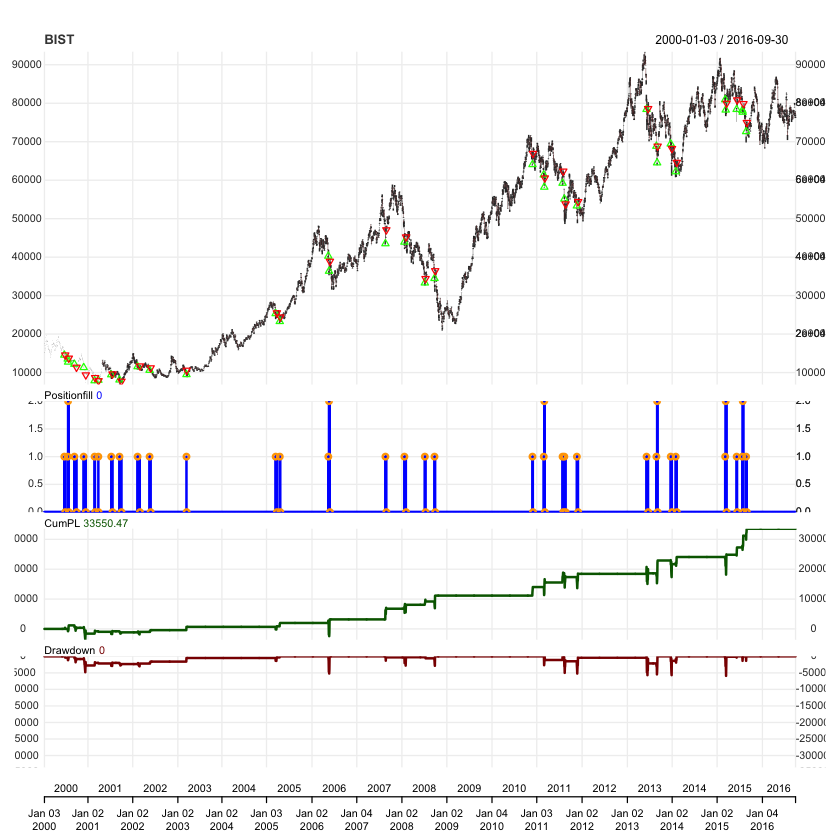

In [19]:
# Update portfolio & account
updatePortf(portfolio.st)
updateAcct(account.st)
updateEndEq(account.st)

# Analyze performance
chart.Posn(portfolio.st, "BIST")

In [20]:
getEndEq(account.st,.to) # We have nearly doubled the equity

[1] 63550.47

### The Strategy Works. Now We can Optimize it

In [21]:
param_s = c(1, 1.5, 2, 2.5, 3)
param_s2 = c(1, 1.5, 2, 2.5, 3)
param_c = c(10,20,30,40)

In [22]:
add.distribution(strategy.st,
                 paramset.label = 'Paramset',
                 component.type = 'indicator',
                 component.label = 'bband_open',
                 variable = list(sd = param_s),
                 label = 'bband_open_dist'
)

add.distribution(strategy.st,
                 paramset.label = 'Paramset',
                 component.type = 'indicator',
                 component.label = 'bband_close',
                 variable = list(sd = param_s2),
                 label = 'bband_close_dist'
)

add.distribution(strategy.st,
                 paramset.label = 'Paramset',
                 component.type = 'signal',
                 component.label = 'rsilong',
                 variable = list(threshold = param_c),
                 label = 'rsilong_dist'
)

[1] "OverSold"

[1] "OverSold"

[1] "OverSold"

In [23]:
add.distribution.constraint(strategy.st,
                            paramset.label = 'Paramset',
                            distribution.label.1 = 'bband_open_dist',
                            distribution.label.2 = 'bband_close_dist',
                            operator = '>',
                            label = 'bband_constraint'
)

[1] "OverSold"

In [24]:
summary(get("OverSold",envir = .strategy))

            Length Class  Mode     
name        1      -none- character
assets      0      -none- NULL     
indicators  3      -none- list     
signals     4      -none- list     
rules       3      -none- list     
constraints 0      -none- NULL     
init        0      -none- list     
wrapup      0      -none- list     
call        3      -none- call     
paramsets   1      -none- list     

### Regular Optimization

In [25]:
detectCores()

[1] 8

In [26]:
registerDoParallel(cores=8) # Parallel computing

# Use nsamples if you want random samples from the parameter space
results <- apply.paramset(strategy.st, 
                          paramset.label='Paramset', 
                          portfolio.st=portfolio.st, 
                          account.st=account.st, 
                          verbose=FALSE)

In [27]:
stats <- results$tradeStats
stats[order(stats[,"Profit.To.Max.Draw"],decreasing = T),
      c("bband_open_dist","bband_close_dist","rsilong_dist","Profit.To.Max.Draw","Ann.Sharpe","End.Equity")]

,bband_open_dist,bband_close_dist,rsilong_dist,Profit.To.Max.Draw,Ann.Sharpe,End.Equity
33,2.5,1.0,40,5.68585538,11.20491031,33550.47
30,3.0,2.5,30,3.17455318,NA,1763.75
32,2.0,1.0,40,2.27126101,5.14797437,30609.83
36,2.5,1.5,40,2.05724439,5.66607957,17066.92
25,2.0,1.5,30,2.01660827,11.78416881,5709.26
35,2.0,1.5,40,1.94390304,4.10968690,20722.92
31,1.5,1.0,40,1.29074363,3.75429152,24142.34
34,3.0,1.0,40,1.28514157,7.17235596,7504.43
38,2.5,2.0,40,1.07506335,2.71280130,8395.89
23,2.5,1.0,30,0.90628261,20.93256083,5158.76


### Walk Forward Optimization

In [28]:
wfa_results <-walk.forward(
  strategy.st=strategy.st, 
  portfolio.st=portfolio.st, 
  account.st=account.st,
  paramset.label='Paramset', # Use this paramset
  period='months', 
  k.training=36, # Optimize over last 36 months
  k.testing=12, # Trade with optimized params during next 12 months
  #nsamples=10, # Only search for 10 param combos
  #obj.func=function(x){which(x == max(x,na.rm=T))}, 
  #obj.args=list(x=quote(tradeStats.list$Profit.To.Max.Draw)), #Obj fnc
  #audit.prefix='wfa', # Will be used in creating RData filenames
  anchored=FALSE) # Rolling WFA, not anchored

[1] "=== training Paramset on 2000-01-03/2002-12-31"
[1] "=== testing param.combo 25 on 2003-01-02/2003-12-31"
   bband_open_dist bband_close_dist rsilong_dist
25               2              1.5           30
[1] "=== training Paramset on 2001-01-02/2003-12-31"
[1] "=== testing param.combo 31 on 2004-01-02/2004-12-29"
   bband_open_dist bband_close_dist rsilong_dist
31             1.5                1           40
[1] "2004-05-07 00:00:00 BIST 1 @ 17624.05"
[1] "2004-05-14 00:00:00 BIST 1 @ 16645.92"
[1] "2004-05-24 00:00:00 BIST -2 @ 16628.77"
[1] "=== training Paramset on 2002-01-02/2004-12-29"
[1] "=== testing param.combo 32 on 2005-01-03/2005-12-30"
   bband_open_dist bband_close_dist rsilong_dist
32               2                1           40
[1] "2005-03-17 00:00:00 BIST 1 @ 25331.7"
[1] "2005-03-22 00:00:00 BIST 1 @ 24636.68"
[1] "2005-04-18 00:00:00 BIST 1 @ 23853.34"
[1] "=== training Paramset on 2003-01-02/2005-12-30"
[1] "=== testing param.combo 32 on 2006-01-02/2006-12-29

In [29]:
wfa_stats = wfa_results[[1]]$apply.paramset$tradeStats


In [30]:
wfa_stats[order(wfa_stats[,"Profit.To.Max.Draw"],decreasing = T),
      c("bband_open_dist","bband_close_dist","rsilong_dist","Profit.To.Max.Draw","Ann.Sharpe","End.Equity")]

,bband_open_dist,bband_close_dist,rsilong_dist,Profit.To.Max.Draw,Ann.Sharpe,End.Equity
40,3.0,2.5,40,1.49990932,9.0604110,578.92
25,2.0,1.5,30,1.49312286,20.2637968,4227.21
31,1.5,1.0,40,1.29905729,9.2297228,3418.82
22,2.0,1.0,30,0.74343965,97.3415555,2220.00
39,3.0,2.0,40,0.73096355,3.0965299,282.13
34,3.0,1.0,40,0.53108477,5.0542982,739.27
35,2.0,1.5,40,0.37220127,5.1538522,2779.64
37,3.0,1.5,40,0.28701149,2.4456900,399.52
32,2.0,1.0,40,0.15932603,3.3067361,1159.97
33,2.5,1.0,40,-0.08603191,-0.7430826,-412.64


### Apply the Best Results from WFA

[1] "2000-06-19 00:00:00 BIST 1 @ 14544"
[1] "2000-07-14 00:00:00 BIST 1 @ 13522"
[1] "2000-07-18 00:00:00 BIST 1 @ 12737"
[1] "2000-09-08 00:00:00 BIST 1 @ 12172"
[1] "2000-11-21 00:00:00 BIST 1 @ 11313.97"
[1] "2001-02-22 00:00:00 BIST 1 @ 7890.4"
[1] "2001-03-30 00:00:00 BIST 1 @ 8022.72"
[1] "2001-07-11 00:00:00 BIST 1 @ 9445.38"
[1] "2001-09-14 00:00:00 BIST 1 @ 8089.46"
[1] "2002-02-11 00:00:00 BIST 1 @ 11541.85"
[1] "2002-05-20 00:00:00 BIST 1 @ 10609.89"
[1] "2003-03-18 00:00:00 BIST 1 @ 9482.92"
[1] "2005-03-17 00:00:00 BIST 1 @ 25331.7"
[1] "2005-04-19 00:00:00 BIST 1 @ 23285.94"
[1] "2006-05-16 00:00:00 BIST 1 @ 40268.68"
[1] "2006-05-23 00:00:00 BIST 1 @ 36351.06"
[1] "2007-08-17 00:00:00 BIST 1 @ 43503.82"
[1] "2008-01-22 00:00:00 BIST 1 @ 43916.65"
[1] "2008-07-02 00:00:00 BIST 1 @ 33308.06"
[1] "2008-09-16 00:00:00 BIST 1 @ 34475.45"
[1] "2010-11-30 00:00:00 BIST 1 @ 64072.16"
[1] "2011-02-25 00:00:00 BIST 1 @ 61389.89"
[1] "2011-03-02 00:00:00 BIST 1 @ 58204.85"
[1] "20

[1] "MeanReversion"

[1] "Investiphi"

[1] "Investiphi"

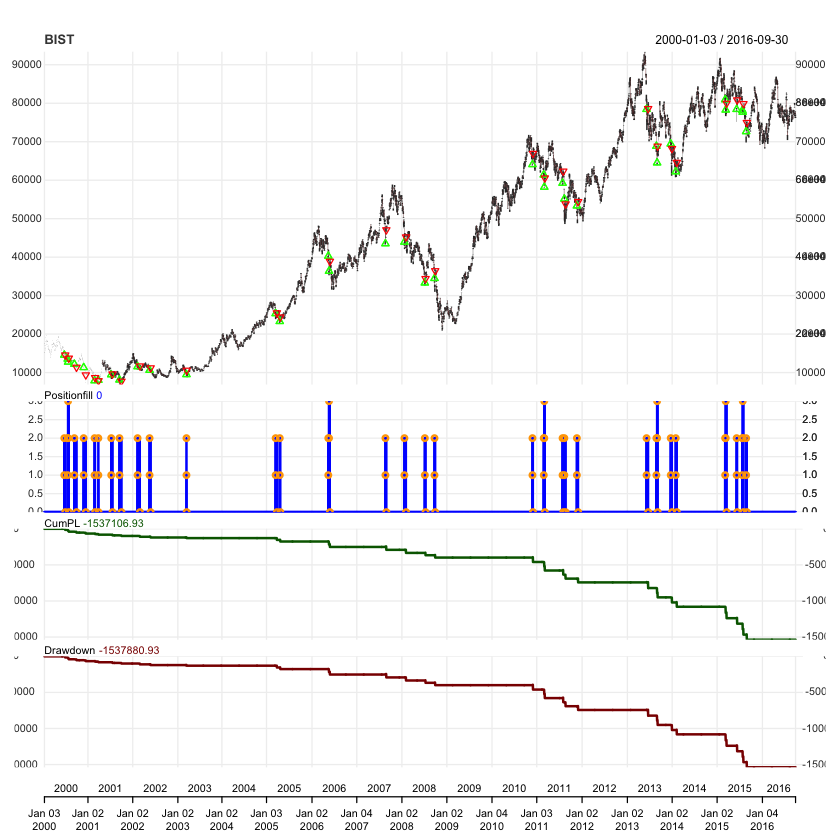

In [78]:
.period = 21
.std_open = 2
.std_close = 1.5
.rsi_t = 30
applyStrategy(strategy.st, portfolio.st)

# Update portfolio & account
updatePortf(portfolio.st)
updateAcct(account.st)
updateEndEq(account.st)

# Analyze performance
chart.Posn(portfolio.st, "BIST")

In [62]:
getEndEq(account.st,.to)

[1] 63550.47